# Generating data

This notebook contains a step-by-step walkthrough for data generation. Data are generated using a custom module, [`wiscs`](https://github.com/w-decker/wiscs). This module takes in a set of parameters in the form of a python dictionary.

## Recommendations
1. It is necessary that you install `wiscs`. The first cell under [Imports](#imports) installs the module via `pip`.
2. Read the comments in each cell carefully. There are instructions for what code may require modification. 

## Plots
Plots showing the data are located at the [end](#visualizing-the-data) of this notebook.

## Imports

In [16]:
# If you have not installed `wiscs` locally, run this cell
!pip install git+https://github.com/w-decker/wiscs.git --quiet # REQUIRED FOR THIS NOTEBOOK
!pip install git+https://github.com/w-decker/rinterface.git --quiet # REQUIRED FOR THIS NOTEBOOK

In [9]:
# always run this cell, no matter which method you choose
import wiscs
from wiscs.simulate import DataGenerator
from wiscs.utils import make_tasks
import numpy as np

import rinterface.rinterface as R
from rinterface.utils import to_r

## Generate your own data by modifying the parameters dictionary

### The `params` dictionary

`params` is a dictionary broken up into six basic components. The first three are related to our hypothetical models of conceptual processing: perceptual, conceptual and task. These are each split by modality. Additionally, you must provide parameters related to variance that will be injected at various levels of the experiment. You must also supply correlation matrices to simulate correlated random effects (if you wish to have independent random effect, simply provide an identity matrix). Finally you must provide basic experimental design choices, like the number of subjects, etc. `<modality>.task` takes in an array of number that is the same length as the number of questions. `make_tasks()` permuates an array of linearly spaced numbers to quickly generate some values for you.

### Setting variance 
All parameters related to variance are prepended with the prefix `"sd"`. Only two are required: `"sd.subject"` and `"sd.error"`. All others are optional. With the exception of `"sd.error"` (and a special case for `"sd.subject"` which will be addressed momentarily), when given a value, a random intercept is generated for that variable. Otherwise, a value of `None` means that no noise is added on behalf of that particular factor. If you give `"sd.subject"` a covariance matrix, it will generate a random slope for questions across subjects.

### `sd.re_formula`
To tell the program how to understand the values you've given it (specifically the variance parameters), you must provide it with a random effects formula, identical to one that you would put into `lme4` (note that not all effects structured are supported, and `modality` and `question` are hard coded as fixed effects). 

In [2]:
# If you wish to generate data based on parameters you wish to define directly in the code, modify + run this cell
########################################################################################
task = make_tasks(low=100, high=200, n=5) # <-- CHANGE THIS AS NEEDED
print(f'Task "times": {task}')
########################################################################################
params = {
    'word.perceptual': 100,
    'image.perceptual': 95,

    'word.conceptual': 100,
    'image.conceptual': 100,

    'word.task': task,
    'image.task': task,

    'sd.item': None, # <-- CHANGE THIS AS NEEDED
    'sd.question': None, # <-- CHANGE THIS AS NEEDED
    'sd.subject': 20, # <-- CHANGE THIS AS NEEDED
    "sd.modality": None, # <-- CHANGE THIS AS NEEDED
    "sd.error": 50,
    "sd.re_formula": "(1|subject)", # <-- CHANGE THIS AS NEEDED

    "corr.subject": np.array([[1]]), # <-- CHANGE THIS AS NEEDED

    'n.subject': 300, # <-- CHANGE THIS AS NEEDED
    'n.question': 5, # <-- CHANGE THIS AS NEEDED
    'n.item': 10 # <-- CHANGE THIS AS NEEDED
}
########################################################################################
wiscs.set_params(params)

Task "times": [200. 150. 175. 100. 125.]
Params set successfully


In [3]:
# If you are satisfied with the parameters and are ready to generate data, run this cell
DG = DataGenerator()
DG.fit_transform(seed=123)

/opt/homebrew/anaconda3/envs/wiscs-stats/lib/python3.12/site-packages/wiscs/simulate.py:211: UserWarning: Simulating data for MAIN hypothesis.
  warnings.warn("Simulating data for MAIN hypothesis.")


In [4]:
# If you wish to save the data, modify + run this cell

########################################
output_name1 = "simulated_shared.csv" # <-- CHANGE THIS AS NEEDED | For example, "simulated_data.csv"
########################################

DG.to_pandas().to_csv(f'../data/{output_name1}', index=False)

## How well are data generated?
Let's give our simulate data to `lme4` and see if it can recover our variance parameters.

In [10]:
script = f"""
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))

df <- {to_r(DG.to_pandas())}

# factorize + treatment coding
df$question <- as.factor(df$question)
df$subject <- as.factor(df$subject)
df$item <- as.factor(df$item)
df$modality <- factor(df$modality, levels = c("word", "image"))
contrasts(df$modality) <- c(-0.5, 0.5)

#  set reference levels
df$question <- relevel(df$question, ref = "0")
df$item <- relevel(df$item, ref = "0")
df$modality <- relevel(df$modality, ref = mean(as.numeric(df$modality)))

m <- lmer(rt ~ modality + question + (1|subject), data = df, REML = FALSE)

VarCorr(m)
"""
R(script)

 Groups   Name        Std.Dev.
 subject  (Intercept) 20.779  
 Residual             49.817  


## Visualizing the data
`wiscs` comes with some default plotting options. The `.plot_bargraph()` method from the `Plot()` class is probably the best way to visualize the data: you can clearly discern between the data which has an interaction of question and one that does not. 

In [5]:
from wiscs.plotting import Plot
P = Plot(DG) # <-- CHANGE THIS AS NEEDED | The `Plot()` class takes in the `DataGenerator()` object

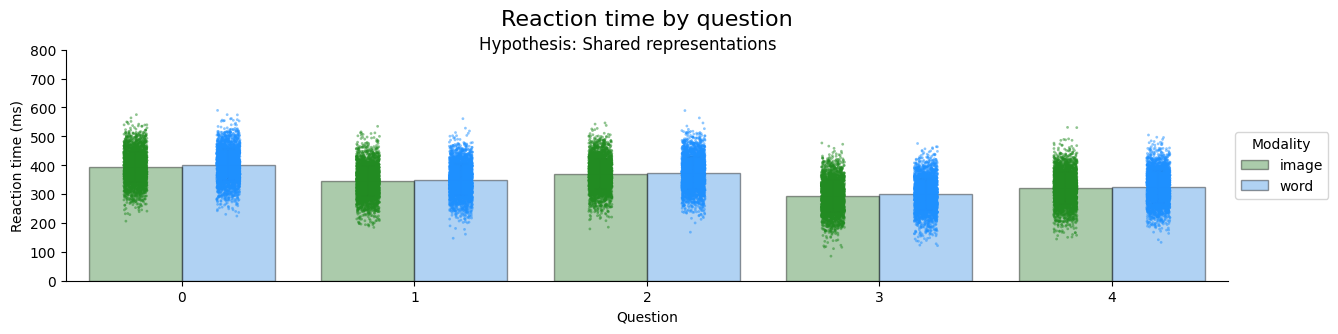

In [6]:
P.plot_bargraph(title="Reaction time by question", hypothesis_title="Hypothesis: Shared representations", show_interaction=False, point_alpah=0.5, point_size=2)

## Testing different values in `params`

`wiscs` makes it easy to update values in the paramters structure without setting them again or running a whole bunch of code. You simply need to provide the key(s) and new value(s) to `DataGenerator().fit_transform({'sd.item':25})` like that. Below is an example with confirmation that the parameter has been updated. 

The ability to dynamically update is critical for power analyses.

In [7]:
print(f'"sd.item" = {DG.params["sd"]["item"]}')

"sd.item" = None


In [8]:
DG.fit_transform(seed=123, params={'sd.item':30}, overwrite=True)
print(f'Updated "sd.item" = {DG.params["sd"]["item"]}')

Updated "sd.item" = 30


/opt/homebrew/anaconda3/envs/wiscs-stats/lib/python3.12/site-packages/wiscs/simulate.py:211: UserWarning: Simulating data for MAIN hypothesis.
  warnings.warn("Simulating data for MAIN hypothesis.")
